Link to Dataset: https://www.kaggle.com/datasets/philosopher0808/real-vs-ai-generated-faces-dataset

Lie, Samuel Miracle Kristanto - 0706012210011
Nathan Darrell - 0706012210034

In [129]:
import tensorflow as tf

print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print("\n\nNumber of GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

2.16.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8837315098176131026
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 3142959874247665296
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]


Number of GPUs Available:  1


2025-06-02 12:30:20.865363: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-02 12:30:20.865421: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [130]:
# from google.colab import drive
# drive.mount('/content/drive')

## Read Dataset & Preprocessing

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

import warnings
warnings.filterwarnings('ignore')

In [132]:
import os

data_dir = "/Users/attraqtia/Documents/ComVis/data_source"
print(os.listdir(data_dir))

['.DS_Store', 'real1', 'fake1', 'real2', 'fake2']


In [133]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Rescaling

# Directory of split folders
split_base = '/Users/attraqtia/Documents/ComVis/data_source'
image_size = (224, 224)
batch_size = 32

def get_image_paths_and_labels(base_dir):
    image_paths = []
    labels = []

    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        label = 0 if folder.startswith('real') else 1  # real = 0, fake = 1
        for f in os.listdir(folder_path):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(folder_path, f))
                labels.append(label)

    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(split_base)

# Split manually into train/val
from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.25, random_state=123, stratify=labels
)

def process_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.cast(img, tf.float32) / 255.0  # normalize
    return img, label

# Build train dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build val dataset
validation_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
validation_ds = validation_ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
validation_ds = validation_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [134]:
print(f"Total images found: {len(image_paths)}")
print(f"Using {len(train_paths)} images for training.")
print(f"Using {len(val_paths)} images for validation.")

num_real = sum(1 for label in labels if label == 0)
num_fake = sum(1 for label in labels if label == 1)

print(f"Class distribution:")
print(f"Real images: {num_real}")
print(f"Fake images: {num_fake}")


Total images found: 40000
Using 30000 images for training.
Using 10000 images for validation.
Class distribution:
Real images: 20000
Fake images: 20000


## Model Building --> MobileNetV3

In [135]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    # RandomZoom(0.1),
    # RandomContrast(0.1),
    # layers.RandomBrightness(0.1),
])

In [136]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC

from tensorflow.keras.optimizers import AdamW

def inverted_residual_block(x, input_channels, output_channels, expansion_factor, strides):
    x_input = x  # Save for residual connection
    expanded_channels = int(input_channels * expansion_factor)

    if expansion_factor != 1:
        x = Conv2D(expanded_channels, kernel_size=1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(output_channels, kernel_size=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if strides == 1 and input_channels == output_channels:
        x = Add()([x_input, x])

    return x


def MobileNetV3_Model(input_shape=(224, 224, 3), num_classes=1):
    # Pake augmentationnya
    input = Input(shape=input_shape)
    x = data_augmentation(input)
    x = Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = inverted_residual_block(x, 16, 16, expansion_factor=1, strides=1)
    x = inverted_residual_block(x, 16, 24, expansion_factor=4, strides=2)
    x = inverted_residual_block(x, 24, 24, expansion_factor=3, strides=1)
    x = inverted_residual_block(x, 24, 40, expansion_factor=3, strides=2)
    x = inverted_residual_block(x, 40, 40, expansion_factor=3, strides=1)
    x = inverted_residual_block(x, 40, 80, expansion_factor=6, strides=2)
    x = inverted_residual_block(x, 80, 80, expansion_factor=2.5, strides=1)

    x = Conv2D(1280, kernel_size=1, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GlobalAveragePooling2D()(x)
    # x = BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=input, outputs=output)

    model.compile(
        optimizer='adam',
        # optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5),
        loss=BinaryCrossentropy(label_smoothing=0.05),
        #  Referensi: Müller et al., 2019. "When Does Label Smoothing Help?"
        metrics=[
            'accuracy',
            Precision(name="precision"),
            Recall(name="recall"),
            AUC(name="auc")
        ]
    )

    return model

In [137]:
model = MobileNetV3_Model(input_shape=(224, 224, 3))
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 224, 224,  │          0 │ input_layer_17[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 112, 112,  │        432 │ sequential_9[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_120 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_56 │ (None, 112, 112,  │        144 │ re_lu_120[0][0]   │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_121 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 112, 112,  │        256 │ re_lu_121[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_122[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 112, 112,  │          0 │ re_lu_120[0][0],  │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_123 (Conv2D) │ (None, 112, 112,  │      1,024 │ add_32[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_123[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_122 (ReLU)    │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_57 │ (None, 56, 56,    │        576 │ re_lu_122[0][0]   │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_123 (ReLU)    │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 205,057 (801.00 KB)

 Trainable params: 198,753 (776.38 KB)

 Non-trainable params: 6,304 (24.62 KB)

In [138]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True)

In [139]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)

In [140]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = dict(enumerate(class_weights))

In [141]:
from datetime import datetime

start_time = datetime.now()

history = model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = 25,
    validation_data = validation_ds,
    verbose = 1,
    callbacks=[lr_callback, early_stop],
    # class_weight=class_weights_dict
)

end_time = datetime.now()

model.save('/Users/attraqtia/Documents/ComVis/reyalfakeh.keras')

Epoch 1/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 286s 280ms/step - accuracy: 0.5954 - auc: 0.6312 - loss: 0.6823 - precision: 0.5901 - recall: 0.6209 - val_accuracy: 0.5012 - val_auc: 0.5786 - val_loss: 1.5980 - val_precision: 0.8333 - val_recall: 0.0030 - learning_rate: 0.0010
Epoch 2/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 256s 273ms/step - accuracy: 0.6132 - auc: 0.6559 - loss: 0.6645 - precision: 0.6084 - recall: 0.6363 - val_accuracy: 0.5074 - val_auc: 0.5726 - val_loss: 0.7815 - val_precision: 0.5837 - val_recall: 0.0516 - learning_rate: 0.0010
Epoch 3/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 268s 286ms/step - accuracy: 0.6161 - auc: 0.6608 - loss: 0.6610 - precision: 0.6112 - recall: 0.6362 - val_accuracy: 0.5925 - val_auc: 0.6670 - val_loss: 0.7023 - val_precision: 0.7208 - val_recall: 0.3020 - learning_rate: 0.0010
Epoch 4/25
938/938 ━━━━━━━━━━━━━━━━━━━━ 278s 297ms/step - accuracy: 0.6182 - auc: 0.6611 - loss: 0.6616 - precision: 0.6179 - recall: 0.6246 - val_accuracy: 0.5444 - val_auc: 0.6211 - val_lo

## Model Evaluation & Testing

In [148]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, AUC

model = load_model(
    '/Users/attraqtia/Documents/ComVis/reyalfakeh.keras',
    custom_objects={
        'Precision': Precision,
        'Recall': Recall,
        'AUC': AUC
    }
)

In [150]:
import numpy as np

print("Training Duration: " + str(end_time - start_time))
print("Training")
print("Loss: {:.4f}".format(np.average(history.history['loss'])))
print("Accuracy: {:.4f}".format(np.average(history.history['accuracy'])))
print("Recall: {:.4f}".format(np.average(history.history['recall'])))
print("Precision: {:.4f}".format(np.average(history.history['precision'])))

print("Validation")
print("Loss: {:.4f}".format(np.average(history.history['val_loss'])))
print("Accuracy: {:.4f}".format(np.average(history.history['val_accuracy'])))
print("Recall: {:.4f}".format(np.average(history.history['val_recall'])))
print("Precision: {:.4f}".format(np.average(history.history['val_precision'])))

Training Duration: 1:56:49.053501
Training
Loss: 0.6329
Accuracy: 0.6505
Recall: 0.6562
Precision: 0.6494
Validation
Loss: 0.6967
Accuracy: 0.6313
Recall: 0.5549
Precision: 0.6705


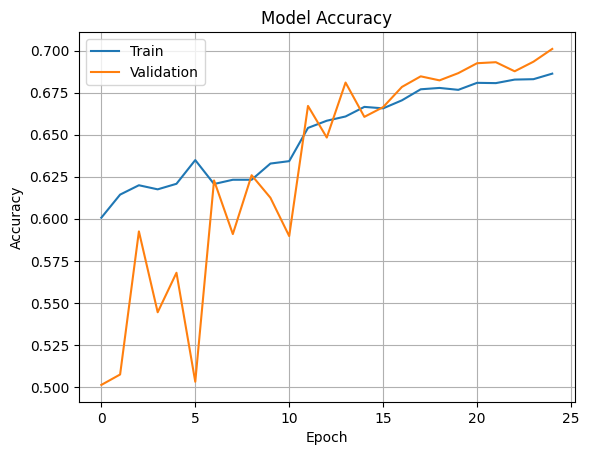

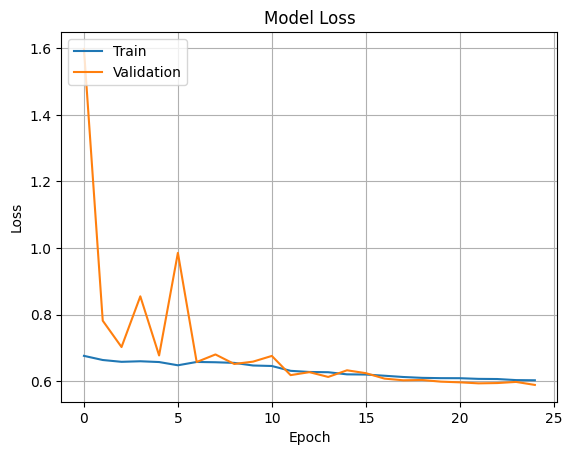

In [151]:
import matplotlib.pyplot as plt

def plotAccuracy(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid()
    plt.show()

def plotLoss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid()
    plt.show()

plotAccuracy(history)
plotLoss(history)

              precision    recall  f1-score   support

        Real       0.71      0.68      0.69      5000
        Fake       0.69      0.72      0.71      5000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



2025-06-02 14:32:56.366874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


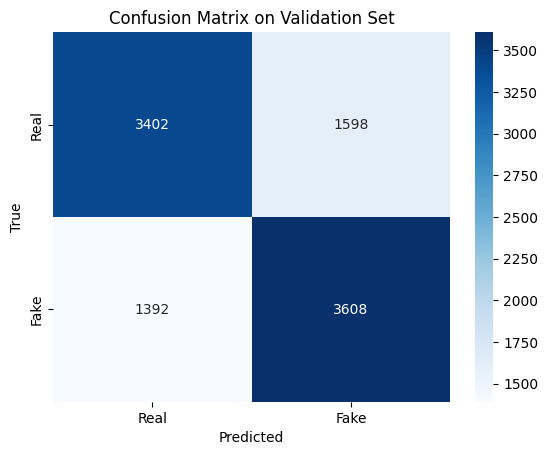

In [152]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []
y_prob = []

for images, labels in validation_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
    y_prob.extend(preds.flatten())

# Classification report
print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Validation Set")
plt.show()

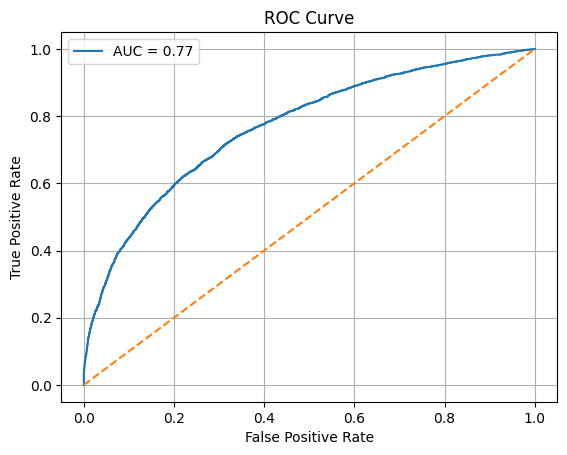

In [153]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

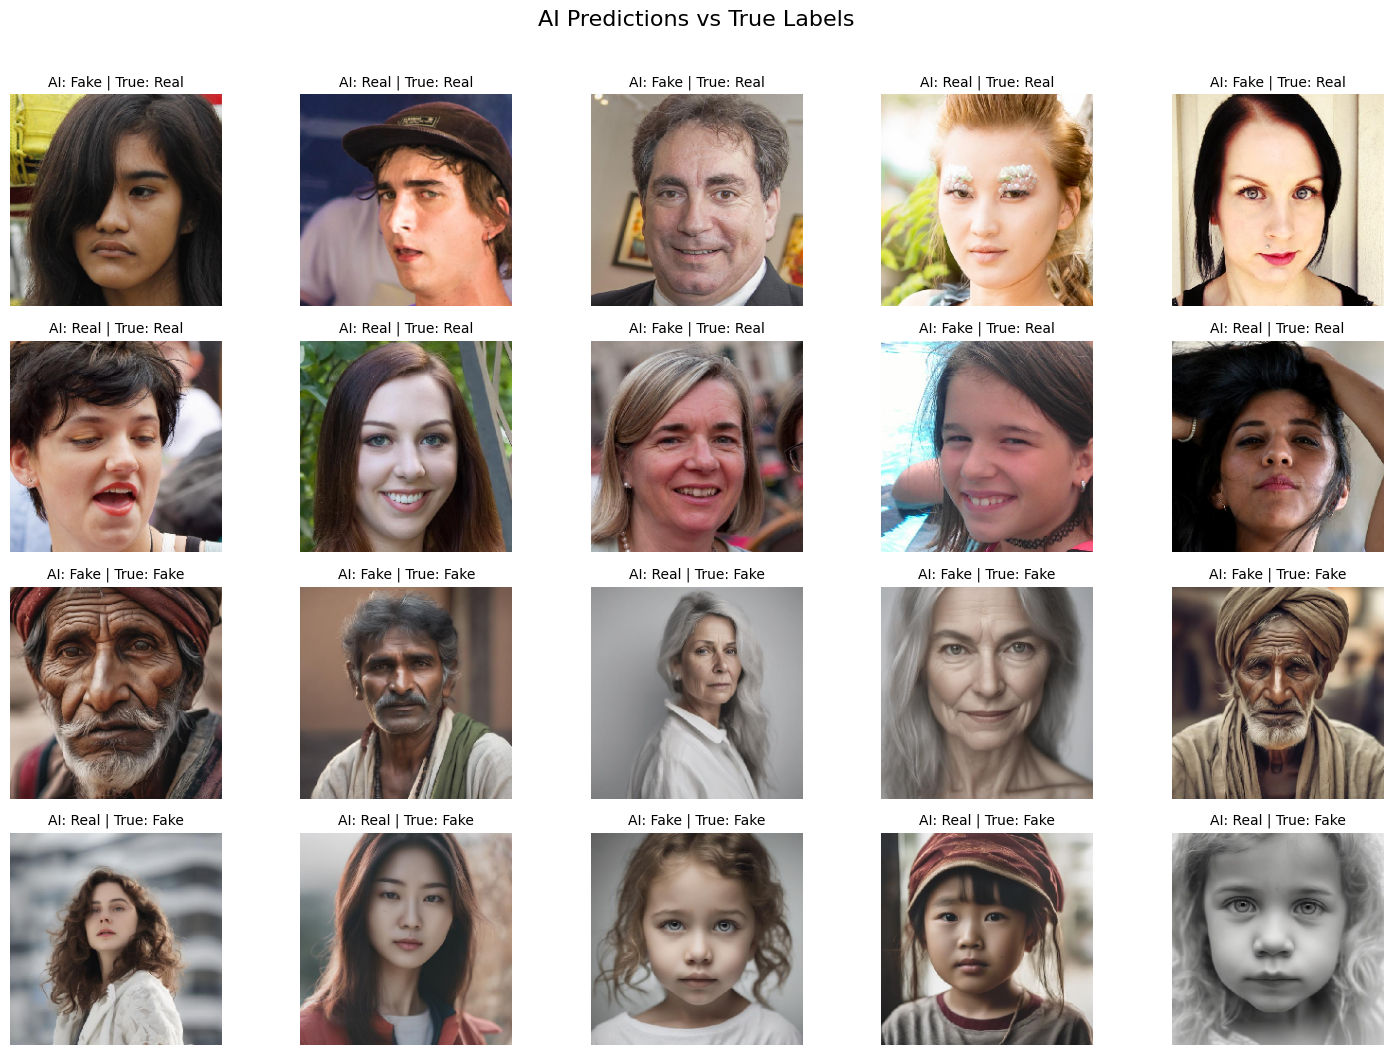

In [160]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

test_base = '/Users/attraqtia/Documents/ComVis/Test'
IMG_SIZE = (224, 224)

label_map = {
    'real8': 0,
    'fake6': 1
}

true_labels = []
predicted_labels = []

# Setup plot
plt.figure(figsize=(15, 10))
i = 1  # subplot index

for folder, label in label_map.items():
    folder_path = os.path.join(test_base, folder)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for img_file in image_files[:10]:  # limit per folder
        img_path = os.path.join(folder_path, img_file)
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array_expanded = tf.expand_dims(img_array, 0) / 255.0

        prediction = model.predict(img_array_expanded, verbose=0)
        predicted = 1 if prediction[0][0] > 0.5 else 0

        true_labels.append(label)
        predicted_labels.append(predicted)

        # String labels
        pred_str = "Fake" if predicted == 1 else "Real"
        true_str = "Fake" if label == 1 else "Real"

        # Plotting
        plt.subplot(4, 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"AI: {pred_str} | True: {true_str}", fontsize=10)
        i += 1

        if i > 20:
            break
    if i > 20:
        break

plt.tight_layout()
plt.suptitle("AI Predictions vs True Labels", fontsize=16, y=1.05)
plt.show()
